In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(0)

In [2]:
def NN_plot(nn):
    nn.compile(loss = 'mse')
    xgrid = np.linspace(-10,10,201)
    y = nn.predict(xgrid)
    plt.plot(xgrid,y)
    plt.grid()
#     plt.show()

In [3]:
# Control Neural Network: u(x)
inputs = keras.Input(shape=(1))
l1 = layers.Dense(8, activation = 'elu')
l2= layers.Dense(1, activation = 'linear')
outputs = l1(inputs)
outputs = l2(outputs)
# outputs = -inputs
control_NN = keras.Model(inputs=inputs, outputs=outputs, name = 'control_NN')
# control_NN.summary()
# NN_plot(control_NN)

In [4]:
# Global Parameter
steps = 100
dt = 0.1
sqrtdt = np.sqrt(dt)
T = steps * dt
M = 1000

In [5]:
a = 2*(np.sqrt(2) - 1)
b = 2 - np.sqrt(2)
rho = (2*np.sqrt(2) - 1)/2
mu = 1/2
var = np.sqrt(1/8)
def u_optimal(x):
    return -0.5*(a*x + b)

def MR(u,x):
    return (u + 1 -x)

In [6]:
input_x = keras.Input(shape=(1))
inputs = [input_x]

X_now = input_x
u_now = control_NN(X_now)
loss = tf.math.square(X_now) + tf.math.square(u_now)
loss_output = [loss]
for i in range(steps):
    input_dW = keras.Input(shape=(1))
    inputs = inputs + [input_dW]
    u_now = control_NN(X_now)
    X_next  = X_now + input_dW + MR(u_now,X_now)*dt
    loss_tmp = (tf.math.square(X_now) + tf.math.square(u_now))* dt
    loss_output = loss_output + [loss_tmp]
    loss = loss + loss_tmp
    X_now = X_next
outputs = loss 

control_main = keras.Model(inputs=inputs, outputs = outputs, name = 'control_main')
control_terminal = keras.Model(inputs=inputs, outputs = X_now, name = 'control_terminal')
control_loss = keras.Model(inputs=inputs, outputs = loss_output, name = 'control_loss')
# control_loss.summary()

control_main.compile(loss = 'mean_absolute_error')
control_terminal.compile(loss = 'mean_absolute_error')
control_loss.compile(loss = 'mean_absolute_error')

In [7]:
def trainning_data(seed,X0,samplesM):
    np.random.seed(seed)
    x = [X0]
    for i in range(steps):
        x = x + [np.random.normal(0,sqrtdt,size = (samplesM,1))]
    y = np.zeros(shape = (samplesM,1))
    return x, y

In [8]:
X0 = np.random.normal(mu,np.sqrt(var),size = (M,1))
# X0 = np.ones(shape = (M,1))
# X0 = np.zeros(shape = (M,1))
x_train, y_train = trainning_data(0,X0,M)
x_valid, y_valid = trainning_data(1,X0,M)
x_test, y_test = trainning_data(2,X0,M)

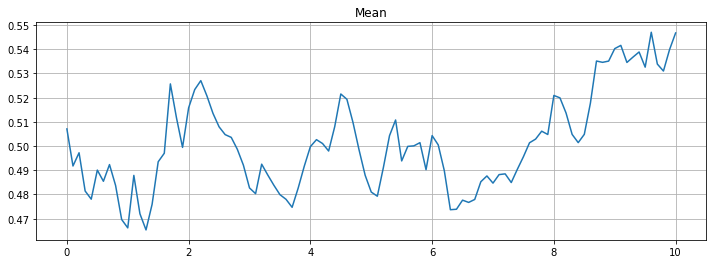

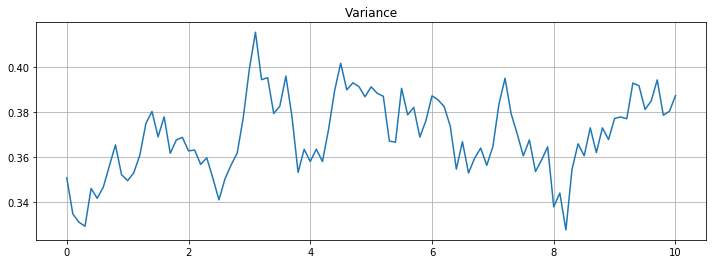

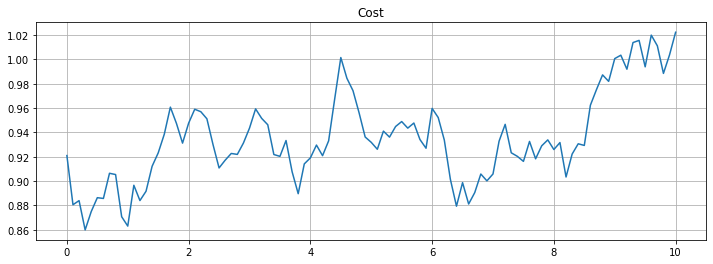

In [9]:
# Optimal control
X = x_train[0][:,0]
rho = np.zeros(steps+1)
rho[0] = np.mean(X)
rho2 = np.zeros(steps+1)
rho2[0] = np.var(X)
rho3 = np.zeros(steps+1)
rho3[0] = np.mean(X**2 + u_optimal(X)**2)
for it in range(steps):
    dW = x_train[it+1][:,0]
    uu = u_optimal(X)
    X  = X + dW + MR(uu,X)*dt
    rho[it+1] = np.mean(X)
    rho2[it+1] = np.var(X)
    rho3[it+1] = np.mean(X**2 + u_optimal(X)**2)
    
plt.rcParams['figure.figsize'] = (12.0, 4.0)
dates = np.linspace(0,steps*dt,steps+1)
plt.plot(dates,rho)
plt.title('Mean')
plt.grid()
plt.show()
plt.plot(dates,rho2)
plt.title('Variance')
plt.grid()
plt.show()
plt.plot(dates,rho3)
plt.title('Cost')
plt.grid()
plt.show()

In [10]:
control_main.evaluate(x_train,y_train)
control_main.fit(x_train,y_train,epochs = 20,validation_data = (x_valid,y_valid), verbose = 1)

1000/1000 [==============================] - 3s 3ms/sample - loss: 106.0081
Train on 1000 samples, validate on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 15s 15ms/sample - loss: 63.9914 - val_loss: 43.2468
Epoch 2/20
1000/1000 [==============================] - 2s 2ms/sample - loss: 32.4832 - val_loss: 24.8537
Epoch 3/20
1000/1000 [==============================] - 2s 2ms/sample - loss: 19.5874 - val_loss: 16.1375
Epoch 4/20
1000/1000 [==============================] - 2s 2ms/sample - loss: 13.7831 - val_loss: 12.5987
Epoch 5/20
1000/1000 [==============================] - 2s 2ms/sample - loss: 11.5926 - val_loss: 11.3391
Epoch 6/20
1000/1000 [==============================] - 2s 2ms/sample - loss: 10.8270 - val_loss: 10.7785
Epoch 7/20
1000/1000 [==============================] - 2s 2ms/sample - loss: 10.4044 - val_loss: 10.4646
Epoch 8/20
1000/1000 [==============================] - 2s 2ms/sample - loss: 10.2203 - val_loss: 10.3741
Epoch 9/20
1000/1000 [====

mean cost:  0.9959214031425452
terminal mean after 1 iteration:  0.0009630594
terminal variance after 1 iteration:  0.59482723


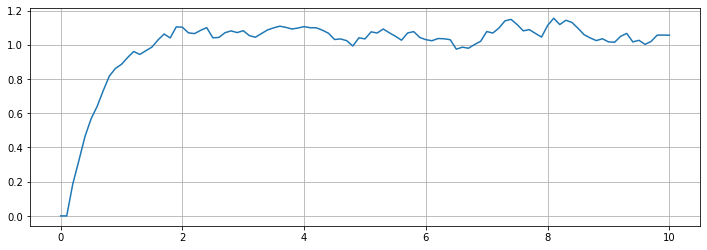

In [10]:
all_loss = control_loss.predict(x_test)
plt_loss = np.zeros(steps+1)
for i,x in enumerate(all_loss):
    plt_loss[i] = x.mean()
plt.plot(dates,plt_loss)
plt.grid()
X_end = control_terminal.predict(x_test)

print('mean cost: ', plt_loss.mean())
print('terminal mean after 1 iteration: ', X_end.mean())
print('terminal variance after 1 iteration: ', X_end.var())

mean cost:  1.0719441777408714
terminal mean after 1 iteration:  0.055210967
terminal variance after 1 iteration:  0.6065921
Train on 1000 samples, validate on 1000 samples
1000/1000 [==============================] - 10s 10ms/sample - loss: 1.0692 - val_loss: 1.0626
mean cost after 2 iteration 1.0584726150673214
terminal mean after 2 iteration:  -0.04688964
terminal variance after 2 iteration:  0.55071044
Train on 1000 samples, validate on 1000 samples
1000/1000 [==============================] - 2s 2ms/sample - loss: 1.0562 - val_loss: 1.0530
mean cost after 3 iteration 1.0447466544585653
terminal mean after 3 iteration:  0.024394218
terminal variance after 3 iteration:  0.5928014
Train on 1000 samples, validate on 1000 samples
1000/1000 [==============================] - 2s 2ms/sample - loss: 1.0703 - val_loss: 1.0688
mean cost after 4 iteration 1.0595857624960419
terminal mean after 4 iteration:  -0.0006363044
terminal variance after 4 iteration:  0.5776902
Train on 1000 samples, v

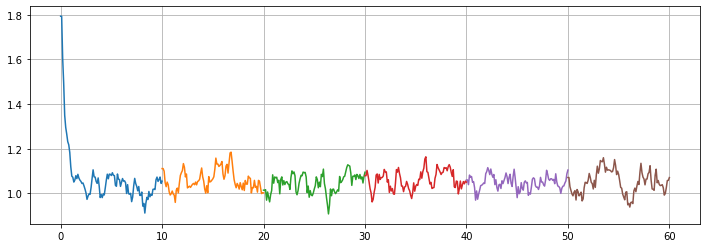

In [11]:
all_loss = control_loss.predict(x_train)
plt_loss = np.zeros(steps+1)
for i,x in enumerate(all_loss):
    plt_loss[i] = x.mean()
plt.plot(dates,plt_loss)
plt.grid()
X_end = control_terminal.predict(x_train)
print('mean cost: ', plt_loss.mean())
print('terminal mean after 1 iteration: ', X_end.mean())
print('terminal variance after 1 iteration: ', X_end.var())

for i in range(5):
#     newX0 = np.random.normal(X_end.mean(),X_end.std(),size = (M,1))
    newX0 = X_end
    x_t, y_t = trainning_data(i+5,newX0,M)
    x_v, y_v = trainning_data(i+500,newX0,M)
    control_main.fit(x_t,y_t,epochs = 1,validation_data = (x_v,y_v), verbose = 1)
    
    all_loss = control_loss.predict(x_t)
    plt_loss = np.zeros(steps+1)
    for j,x in enumerate(all_loss):
        plt_loss[j] = x.mean()
    plt.plot(dates+T*(i+1),plt_loss)
    X_end = control_terminal.predict(x_t)
    print(f'mean cost after {i+2} iteration', plt_loss.mean())
    print(f'terminal mean after {i+2} iteration: ',  X_end.mean())
    print(f'terminal variance after {i+2} iteration: ',  X_end.var())

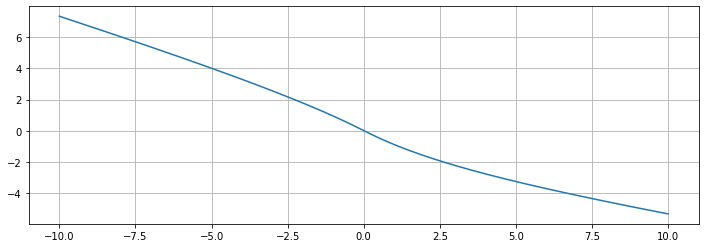

In [12]:
control_NN.compile(loss = 'mse')
xgrid = np.linspace(-10,10,201)
y = control_NN.predict(xgrid)
plt.plot(xgrid,y)
plt.grid()

Iteratively find the optimal control $u$ of finite horizon problem and drive the controlled process with $u$ until the distribution stable. 

Note: Here the optimal control $u$ is computed in a naive way by finding the best $u$ for an initial distribution. Alternative approch can be using the value function $V(t,x)$ which gives the best value not only for a fixed initial distribution but for any distribution. 

This method simply truncated the ergodic problem to the finite horizon problem. This is reasonable when the optimal control of finite horizon problem is closed to the optimal control of ergodic problem, because then the controlled process coverges to the stationay distribution exponentially. 

This method can be extended to multidimensional diffusion control if we can prove that 
1. the optimal control of finite horizonal problem is closed to ergodic one
2. the optimal controlled process converges in distribution exponentially



